In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpyro

NDEVICES = 16
numpyro.set_host_device_count(NDEVICES)

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
import seaborn as sns
import os
from datetime import date, timedelta
from tqdm.auto import tqdm
from collections import defaultdict
import itertools

import numpy as np
import pandas as pd
import jax.numpy as jnp
from jax.random import PRNGKey

import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import mechafil_jax.data as data
import mechafil_jax.sim as sim
import mechafil_jax.constants as C
import mechafil_jax.minting as minting
import mechafil_jax.plot_utils as pu
import mechafil_jax.date_utils as du

import scenario_generator.utils as u
import scenario_generator.curated as curated
import scenario_generator.mcmc_forecast as mcmc

import pystarboard.data

from cel_utils import disk_utils

CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
token = os.path.join(os.environ['HOME'],'code/cel/auth/spacescope_auth.json')
print(os.path.exists(token))

mcmc_train_len_days = 120
current_date = date(2024, 1, 8)

#current_date = date.today() - timedelta(days=3)
start_date = current_date - timedelta(days=3) # get some historical data
current_day = (current_date-start_date).days
forecast_length = 365*2
end_date = current_date + timedelta(days=forecast_length)
print(start_date, current_date, end_date)

True
2024-01-05 2024-01-08 2026-01-07


In [5]:
save_dir = os.path.join(os.environ['HOME'], 'Documents/cel/filecoin_forecasts/%s/%d' % (current_date.strftime('%Y%m%d'), mcmc_train_len_days))
offline_info_dir = os.path.join(save_dir, 'offline_info')
os.makedirs(save_dir, exist_ok=True)
os.makedirs(offline_info_dir, exist_ok=True)

In [66]:
pystarboard.data.setup_spacescope(token)

In [7]:
@disk_utils.cache_data(directory=offline_info_dir)
def download_simulation_data():
    offline_data = data.get_simulation_data(token, start_date, current_date, end_date)
    return {
        'offline_data': offline_data
    }

x = download_simulation_data()
locals().update(x)

In [8]:
offline_data.keys()

dict_keys(['rb_power_zero', 'qa_power_zero', 'historical_raw_power_eib', 'historical_qa_power_eib', 'historical_onboarded_rb_power_pib', 'historical_onboarded_qa_power_pib', 'historical_renewed_qa_power_pib', 'historical_renewed_rb_power_pib', 'rb_known_scheduled_expire_vec', 'qa_known_scheduled_expire_vec', 'known_scheduled_pledge_release_full_vec', 'start_vested_amt', 'zero_cum_capped_power_eib', 'init_baseline_eib', 'circ_supply_zero', 'locked_fil_zero', 'daily_burnt_fil', 'burnt_fil_vec', 'historical_renewal_rate'])

### Run MCMC Forecast of Network Metrics

In [9]:
# MCMC forecasting configuration
mcmc_train_start_date = current_date - timedelta(days=(mcmc_train_len_days))
mcmc_train_end_date = mcmc_train_start_date + timedelta(days=mcmc_train_len_days)
num_warmup_mcmc = 10000
num_samples_mcmc = 500
seasonality_mcmc = 2000
num_chains_mcmc = 4

In [10]:
def generate_mcmc_forecast_samples(train_start_date: date,
                                   train_end_date: date,
                                   forecast_length: int,
                                   num_warmup_mcmc: int = 500,
                                   num_samples_mcmc: int = 100,
                                   seasonality_mcmc: int = 1000,
                                   num_chains_mcmc: int = 2,
                                   verbose: bool = False):
    print("Forecasting Onboarding Power")
    forecast_rb_date_vec, rb_onboard_power_pred, historical_rb_date, historical_rb, rb_rhats = \
        mcmc.forecast_rb_onboard_power(train_start_date, 
                                       train_end_date,
                                       forecast_length,
                                       num_warmup_mcmc = num_warmup_mcmc,
                                       num_samples_mcmc = num_samples_mcmc,
                                       seasonality_mcmc = seasonality_mcmc,
                                       num_chains_mcmc = num_chains_mcmc,
                                       verbose = verbose)
    
    print("Forecasting Renewal Rate")
    forecast_rr_date_vec, renewal_rate_pred, historical_rr_date , historical_rr, ext_rhats, expire_rhats = \
        mcmc.forecast_renewal_rate(train_start_date, 
                                   train_end_date,
                                   forecast_length,
                                   num_warmup_mcmc = num_warmup_mcmc,
                                   num_samples_mcmc = num_samples_mcmc,
                                   seasonality_mcmc = seasonality_mcmc,
                                   num_chains_mcmc = num_chains_mcmc,
                                   verbose = verbose)
    
    print("Forecasting FIL+ Rate")
    forecast_fpr_date_vec, filplus_rate_pred, historical_fpr_date, historical_fpr, deal_onboard_pred_rhats, cc_onboard_pred_rhats = \
        mcmc.forecast_filplus_rate(train_start_date, 
                                   train_end_date,
                                   forecast_length,
                                   num_warmup_mcmc = num_warmup_mcmc,
                                   num_samples_mcmc = num_samples_mcmc,
                                   seasonality_mcmc = seasonality_mcmc,
                                   num_chains_mcmc = num_chains_mcmc,
                                   verbose = verbose)
    
    diagnostics = {
        'rb_rhats': rb_rhats,
        'ext_rhats': ext_rhats,
        'expire_rhats': expire_rhats,
        'deal_onboard_pred_rhats':deal_onboard_pred_rhats, 
        'cc_onboard_pred_rhats': cc_onboard_pred_rhats
    }
    
    return rb_onboard_power_pred, renewal_rate_pred, filplus_rate_pred, historical_rb_date, historical_rb, historical_rr_date, historical_rr, historical_fpr_date, historical_fpr, diagnostics
    
@disk_utils.cache_data(directory=offline_info_dir)
def run_mcmc():
    rb_onboard_power_pred, renewal_rate_pred, filplus_rate_pred, historical_rb_date, historical_rb, historical_rr_date, historical_rr, historical_fpr_date, historical_fpr, diagnostics = \
        generate_mcmc_forecast_samples(mcmc_train_start_date,
                                       mcmc_train_end_date,
                                       forecast_length,
                                       num_warmup_mcmc,
                                       num_samples_mcmc,
                                       seasonality_mcmc,
                                       num_chains_mcmc,
                                       verbose=True)
    return {
        'rb_onboard_power_pred': rb_onboard_power_pred,
        'renewal_rate_pred': renewal_rate_pred,
        'filplus_rate_pred': filplus_rate_pred,
        'historical_rb_date': historical_rb_date,
        'historical_rb': historical_rb,
        'historical_rr_date': historical_rr_date,
        'historical_rr': historical_rr,
        'historical_fpr_date': historical_fpr_date,
        'historical_fpr': historical_fpr,
        'diagnostics': diagnostics
    }

mcmc_data = run_mcmc()
locals().update(mcmc_data)

# print mcmc diagnostics
rb_rhat_check = mcmc.check_rhat(diagnostics['rb_rhats'])
ext_rhat_check = mcmc.check_rhat(diagnostics['ext_rhats'])
exp_rhat_check = mcmc.check_rhat(diagnostics['expire_rhats'])

print('RBP Forecast RHat < 1.05: %0.02f %%' % (rb_rhat_check*100,))
print('Extensions Forecast RHat < 1.05: %0.02f %%' % (ext_rhat_check*100,))
print('Expirations Forecast RHat < 1.05: %0.02f %%' % (exp_rhat_check*100,))

RBP Forecast RHat < 1.05: 100.00 %
Extensions Forecast RHat < 1.05: 96.12 %
Expirations Forecast RHat < 1.05: 96.12 %


In [11]:
def get_quantiles(jax_arr, qvec=[0.25, 0.5, 0.75]):
    return np.quantile(jax_arr, qvec, axis=0)

In [12]:
# TODO: cache this
# get additional historical data for plotting purposes
hist_plot_tvec_rr, hist_rr = u.get_historical_renewal_rate(current_date-timedelta(days=360), current_date)
hist_plot_tvec_rbp, hist_rbp = u.get_historical_daily_onboarded_power(current_date-timedelta(days=360), current_date)
hist_plot_tvec_fpr, hist_fpr = u.get_historical_filplus_rate(current_date-timedelta(days=360), current_date)

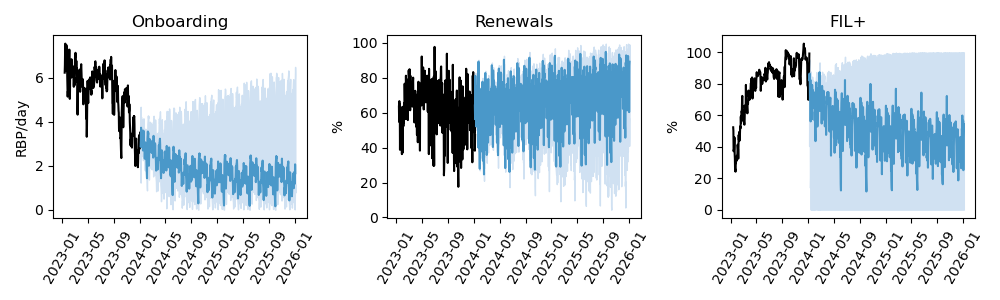

In [13]:
# plot historical trends
t_pred = pd.date_range(historical_rb_date.iloc[-1]+timedelta(days=1), periods=forecast_length, freq='D')

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,3), sharex=True)

blues = mpl.colormaps['Blues']
axx = ax[0]
axx.plot(hist_plot_tvec_rbp, hist_rbp, color='k')
# axx.plot(historical_rb_date, historical_rb, color='k')
rbp_quantiles = get_quantiles(rb_onboard_power_pred)
axx.plot(t_pred, rbp_quantiles[1], color=blues(0.6))
axx.fill_between(t_pred, rbp_quantiles[0], rbp_quantiles[2], color=blues(0.2))
axx.set_title('Onboarding')
axx.set_ylabel('RBP/day')
for tick in axx.get_xticklabels(): tick.set_rotation(60)
    
axx = ax[1]
axx.plot(hist_plot_tvec_rr, hist_rr*100, color='k')
# axx.plot(historical_rr_date, historical_rr*100, color='k')
rr_quantiles = get_quantiles(renewal_rate_pred*100)
axx.plot(t_pred, rr_quantiles[1], color=blues(0.6))
axx.fill_between(t_pred, rr_quantiles[0], rr_quantiles[2], color=blues(0.2))
axx.set_title('Renewals')
axx.set_ylabel('%')
for tick in axx.get_xticklabels(): tick.set_rotation(60)

axx = ax[2]
axx.plot(hist_plot_tvec_fpr, hist_fpr*100, color='k')
# axx.plot(historical_fpr_date, historical_fpr*100, color='k')
fpr_quantiles = get_quantiles(filplus_rate_pred*100)
axx.plot(t_pred, fpr_quantiles[1], color=blues(0.6))
axx.fill_between(t_pred, fpr_quantiles[0], fpr_quantiles[2], color=blues(0.2))
axx.set_title('FIL+')
axx.set_ylabel('%')
for tick in axx.get_xticklabels(): tick.set_rotation(60)

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'mcmc_inputs.png'))

In [14]:
lock_target = 0.3
sector_duration = 365

simulation_results_vec = []
for ii in tqdm(range(num_samples_mcmc*num_chains_mcmc)):
    rbp_vec = rb_onboard_power_pred[ii,:]
    rr_vec = renewal_rate_pred[ii,:]
    fpr_vec = filplus_rate_pred[ii,:]
    simulation_results = sim.run_sim(
        rbp_vec,
        rr_vec,
        fpr_vec,
        lock_target,
    
        start_date,
        current_date,
        forecast_length,
        sector_duration,
        offline_data
    )
    simulation_results_vec.append(simulation_results)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [15]:
end_date = current_date + timedelta(forecast_length)
macro_t = du.get_t(start_date, end_date=end_date)

In [16]:
#reconstruct historical power onboarding/pledge/fofr metrics
# TODO: move this into a library function
hist_df = pystarboard.data.get_historical_network_stats(start_date-timedelta(days=360), current_date, end_date)
hist_expire_df = pystarboard.data.query_sector_expirations(start_date-timedelta(days=360), current_date)
hist_econ_df = pystarboard.data.query_sector_economics(
    start_date-timedelta(days=360), 
    current_date, 
)

In [17]:
hist_df['date'] = pd.to_datetime(hist_df['date'])
hist_df.sort_values('date', inplace=True)
hist_expire_df['date'] = pd.to_datetime(hist_expire_df['date']).dt.tz_localize(None)
hist_expire_df.sort_values('date', inplace=True)
hist_df_merged = pd.merge_asof(hist_df, hist_expire_df, on='date')

# TODO: discuss how to compute this properly from historical data directly ... unsure at the moment
# pledge_historical = pd.read_csv('Commit_Pledge_per_32GiB_QAP.csv')
# pledge_historical['date'] = pd.to_datetime(pledge_historical['date'])
# pledge_historical = pledge_historical[pledge_historical['date'] < pd.to_datetime(current_date)]
pledge_historical = hist_econ_df[['date', 'sector_initial_pledge_32gib']]
pledge_historical.rename(columns={'sector_initial_pledge_32gib': 'pledge'}, inplace=True)

hist_df_merged = pd.merge_asof(hist_df_merged, pledge_historical, on='date')

hist_expire_df

In [18]:
# now add the quantities of interest
hist_df_merged['day_network_reward'] = hist_df_merged['mined_fil'].diff()
hist_df_merged['day_network_reward'].iloc[0] = hist_df_merged['day_network_reward'].iloc[1]
hist_df_merged['day_locked_pledge'] = hist_df_merged['locked_fil'].diff()
hist_df_merged['day_renewed_pledge'] = hist_df_merged['extended_pledge'].diff()

hist_df_merged['day_rewards_per_sector'] = C.EIB_PER_SECTOR * hist_df_merged['day_network_reward'] / hist_df_merged['total_qa_power_eib']

/tmp/ipykernel_6722/575488602.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_df_merged['day_network_reward'].iloc[0] = hist_df_merged['day_network_reward'].iloc[1]


In [42]:
hist_plot_tvec = pd.date_range(current_date-timedelta(days=360), current_date, freq='D')

def get_simresults_quantiles(sim_results_vec, key, qvec=[0.25, 0.5, 0.75]):
    key_results = []
    for sr in sim_results_vec:
        key_results.append(np.asarray(sr[key]))  # convert jax to np
    
    return np.nanquantile(np.asarray(key_results), qvec, axis=0)

def plot_mcmc_power_panel(simulation_results_vec):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,4))

    axx = ax[0]
    yy = get_simresults_quantiles(simulation_results_vec, key='rb_total_power_eib')
    axx.plot(hist_df_merged['date'], hist_df_merged['total_raw_power_eib'], color='k')
    axx.plot(macro_t, yy[1], color=blues(0.6))
    axx.fill_between(macro_t, yy[0], yy[2], color=blues(0.2))
    axx.set_ylabel('EiB')
    axx.set_title('RBP')
    # axx.legend(fontsize=8)
    axx.set_ylim(bottom=0)
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.axvline(current_date, color='grey', linestyle='--')
    
    axx = ax[1]
    yy = get_simresults_quantiles(simulation_results_vec, key='qa_total_power_eib')
    axx.plot(hist_df_merged['date'], hist_df_merged['total_qa_power_eib'], color='k')
    axx.plot(macro_t, yy[1], color=blues(0.6))
    axx.fill_between(macro_t, yy[0], yy[2], color=blues(0.2))
    baseline = get_simresults_quantiles(simulation_results_vec, key='network_baseline_EIB', qvec=[0.5])
    axx.plot(macro_t, baseline[0], color='k', linestyle='--', label='Baseline')
    axx.set_ylabel('EiB')
    axx.set_title('QAP')
    axx.legend(fontsize=8)
    axx.set_ylim(bottom=0)
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.axvline(current_date, color='grey', linestyle='--')
    
    axx = ax[2]
    yy = get_simresults_quantiles(simulation_results_vec, key='day_network_reward')
    axx.plot(hist_df_merged['date'], hist_df_merged['day_network_reward'], color='k')
    axx.plot(macro_t, yy[1], color=blues(0.6))
    axx.fill_between(macro_t, yy[0], yy[2], color=blues(0.2))
    axx.set_ylabel('FIL/day')
    axx.set_title('Minting Rate')
    # axx.legend(fontsize=8)
    axx.set_ylim(bottom=0)
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.axvline(current_date, color='grey', linestyle='--')
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'mcmc_power.png'))

def plot_supply_panel(simulation_results_vec):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,4))

    axx = ax[0]
    yy = get_simresults_quantiles(simulation_results_vec, key='network_locked')
    axx.plot(hist_df_merged['date'], hist_df_merged['locked_fil']/1e6, color='k')
    axx.plot(macro_t, yy[1]/1e6, color=blues(0.6))
    axx.fill_between(macro_t, yy[0]/1e6, yy[2]/1e6, color=blues(0.2))
    axx.set_ylabel('M-FIL')
    axx.set_title('Network Locked')
    axx.set_ylim(bottom=0)
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.axvline(current_date, color='grey', linestyle='--')
    axx.axhline(100/5, color='red', linestyle='--', alpha=0.5, label='100M-USD Consensus Pledge Locked \n @$5/FIL')
    axx.legend(fontsize=8, loc='upper right')
    
    axx = ax[1]
    yy = get_simresults_quantiles(simulation_results_vec, key='circ_supply')
    axx.plot(hist_df_merged['date'], hist_df_merged['circulating_fil']/1e6, color='k')
    axx.plot(macro_t, yy[1]/1e6, color=blues(0.6))
    axx.fill_between(macro_t, yy[0]/1e6, yy[2]/1e6, color=blues(0.2))
    axx.set_ylabel('M-FIL')
    axx.set_title('Circulating Supply')
    # axx.legend(fontsize=8)
    axx.set_ylim(bottom=0)
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.axvline(current_date, color='grey', linestyle='--')
    
    key_results = []
    for sr in simulation_results_vec:
        key_results.append(np.asarray(sr['network_locked']/sr['circ_supply']))  # convert jax to np
    lcs_q = np.quantile(np.asarray(key_results), [0.25, 0.5, 0.75], axis=0)
    axx = ax[2]
    axx.plot(hist_df_merged['date'], hist_df_merged['locked_fil']/hist_df_merged['circulating_fil']*100, color='k')
    axx.plot(macro_t, lcs_q[1]*100, color=blues(0.6))
    axx.fill_between(macro_t, lcs_q[0]*100, lcs_q[2]*100, color=blues(0.2))
    axx.set_ylabel('%')
    axx.set_title('L/CS')
    axx.set_ylim(bottom=0)
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.axvline(current_date, color='grey', linestyle='--')
    axx.axhline(30, color='red', linestyle='--', alpha=0.5, label='Lock Target')
    axx.legend(fontsize=8)
    
    plt.suptitle('Supply Metrics')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'mcmc_supply.png'))

def plot_onboarding_panel(simulation_results_vec):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

    axx = ax[0]
    yy = get_simresults_quantiles(simulation_results_vec, key='day_pledge_per_QAP')
    axx.plot(hist_df_merged['date'], hist_df_merged['pledge'], color='k')
    axx.plot(macro_t, yy[1], color=blues(0.6))
    axx.fill_between(macro_t, yy[0], yy[2], color=blues(0.2))
    axx.set_ylabel('FIL')
    axx.set_title('Pledge/32GiB QA Sector')
    # axx.legend(fontsize=8)
    axx.set_ylim(bottom=0)
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.axvline(current_date, color='grey', linestyle='--')
    
    axx = ax[1]
    key_results = []
    for sr in simulation_results_vec:
        # we need to create new time-series and append historical to forecast to compute a smooth FoFR plot
        dpqq_full = np.concatenate([hist_df_merged['pledge'].values, sr['day_pledge_per_QAP']])
        drps_full = np.concatenate([hist_df_merged['day_rewards_per_sector'].values, sr['day_rewards_per_sector']])
        days_1y = 365
        rps_1y = np.convolve(drps_full, np.ones(days_1y), mode='full')[days_1y-1:1-days_1y]
        roi_1y = rps_1y / dpqq_full[:1-days_1y]
        key_results.append(np.asarray(roi_1y*100))

    fofr = np.nanquantile(np.asarray(key_results), [0.25, 0.5, 0.75], axis=0)
    fofr_tvec = pd.date_range(hist_df_merged['date'].iloc[0], periods=len(fofr[0]), freq='D')
    axx.plot(fofr_tvec, fofr[1], color=blues(0.6))
    axx.fill_between(fofr_tvec, fofr[0], fofr[2], color=blues(0.2))
    axx.set_ylabel('%')
    axx.set_title('1Y Realized FoFR')
    axx.set_ylim(bottom=0)
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.axvline(current_date, color='grey', linestyle='--')
    
    plt.suptitle('Onboarding Metrics')
    plt.tight_layout()

    plt.savefig(os.path.join(save_dir, 'mcmc_onboarding.png'))

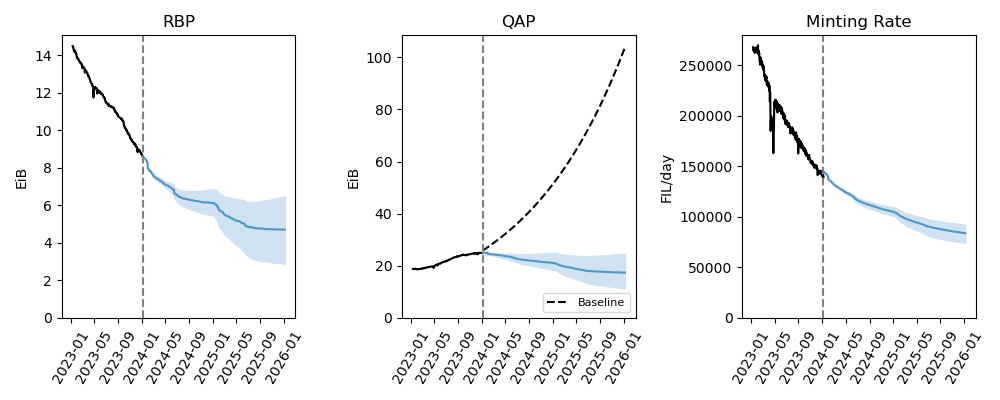

In [43]:
plot_mcmc_power_panel(simulation_results_vec)

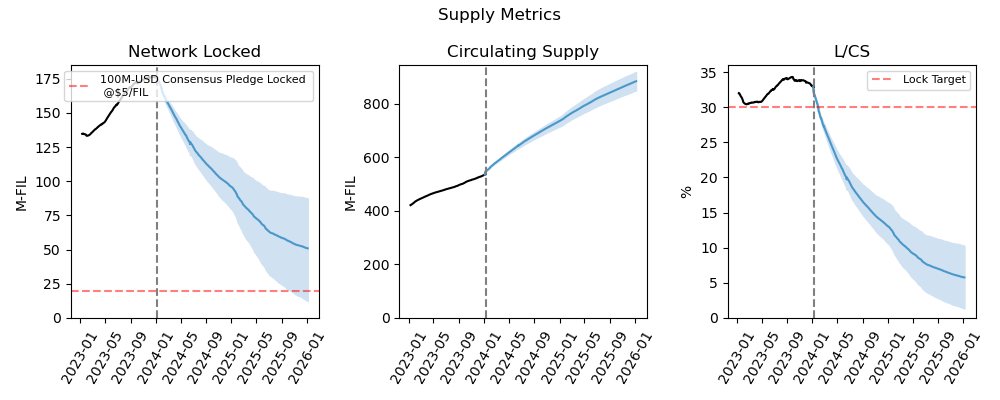

In [44]:
plot_supply_panel(simulation_results_vec)

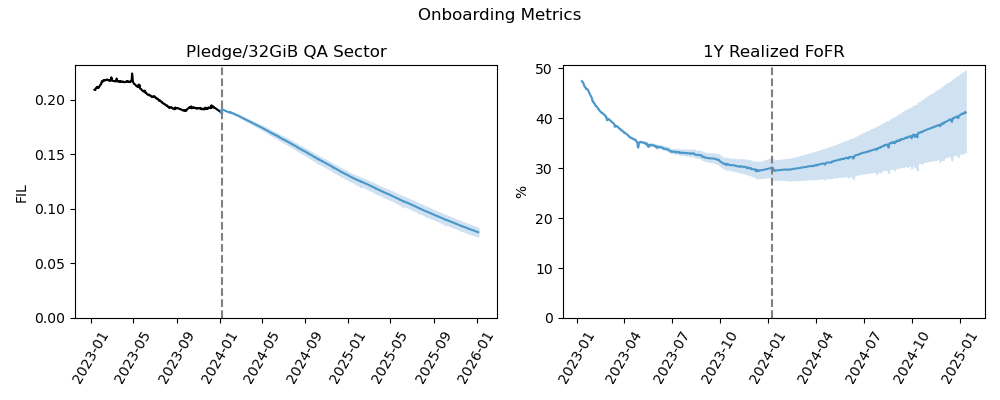

In [45]:
plot_onboarding_panel(simulation_results_vec)

### Run several scenarios scaled from the current Median Rates of RBP, RR, FPR

In [46]:
hist_median_rbp = np.median(historical_rb)
hist_median_rr = np.median(historical_rr)
hist_median_fpr = np.median(historical_fpr)

print(hist_median_rbp, hist_median_rr, hist_median_fpr)

4.17620849609375 0.5846854900127445 0.9543612


In [47]:
rbp_factors = [0.8, 1.2]
rr_factors = [0.8, 1.2]
fpr_factors = [0.8, 1.2]

sim_configs = list(itertools.product(rbp_factors, rr_factors, fpr_factors))
sim_configs.insert(0, (1,1,1))

lock_target = 0.3
sector_duration = 365

simconfig2results = {}
for sim_config in sim_configs:
    rbp_factor, rr_factor, fpr_factor = sim_config
    rbp_vec = jnp.ones(forecast_length) * hist_median_rbp * rbp_factor
    rr_vec = jnp.ones(forecast_length) * min(0.99, hist_median_rr * rr_factor)
    fpr_vec = jnp.ones(forecast_length) * min(0.99, hist_median_fpr * fpr_factor)

    simulation_results = sim.run_sim(
        rbp_vec,
        rr_vec,
        fpr_vec,
        lock_target,
    
        start_date,
        current_date,
        forecast_length,
        sector_duration,
        offline_data
    )
    simconfig2results[sim_config] = simulation_results

In [48]:
def plot_power_scenarios(results_dict):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,4))

    colors = [mpl.colormaps['Blues'], mpl.colormaps['Oranges']]
    intensities = np.linspace(0.3, 0.7, len(rr_factors))
    linestyles = ['-.', ':']
    
    axx = ax[0]
    for sim_config, sim_results in results_dict.items():
        rbp_factor, rr_factor, fpr_factor = sim_config
        if rbp_factor == 1 and rr_factor == 1 and fpr_factor == 1:
            c = 'k'
            l='-'
        else:
            c = colors[rbp_factors.index(rbp_factor)](intensities[rr_factors.index(rr_factor)])
            l = linestyles[fpr_factors.index(fpr_factor)]
            
        axx.plot(macro_t, sim_results['rb_total_power_eib'], color=c, linestyle=l)
    axx.plot(hist_df_merged['date'], hist_df_merged['total_raw_power_eib'], color='k')
    axx.set_ylabel('EiB')
    axx.set_title('RBP')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    # setup the legend
    custom_lines = [
        Line2D([0], [0], color=colors[0](0.3), lw=2),
        Line2D([0], [0], color='k', lw=2),
        Line2D([0], [0], color=colors[1](0.7), lw=2)
    ]
    axx.legend(custom_lines, ['0.8x', '1x', '1.2x'], title='RBP Factor')
    axx.set_ylim(bottom=0)
    axx.axvline(current_date, color='grey', linestyle='--')

    axx = ax[1]
    for sim_config, sim_results in results_dict.items():
        rbp_factor, rr_factor, fpr_factor = sim_config
        if rbp_factor == 1 and rr_factor == 1 and fpr_factor == 1:
            c = 'k'
            l='-'
        else:
            c = colors[rbp_factors.index(rbp_factor)](intensities[rr_factors.index(rr_factor)])
            l = linestyles[fpr_factors.index(fpr_factor)]
            
        axx.plot(macro_t, sim_results['qa_total_power_eib'], color=c, linestyle=l)
    axx.plot(hist_df_merged['date'], hist_df_merged['total_qa_power_eib'], color='k')
    axx.plot(macro_t, sim_results['network_baseline_EIB'], color='k', linestyle='--')
    axx.set_ylabel('EiB')
    axx.set_title('QAP')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    # setup the legend
    # setup the legend
    custom_lines = [
        Line2D([0], [0], color='k', lw=2, linestyle='-.'),
        Line2D([0], [0], color='k', lw=2),
        Line2D([0], [0], color='k', lw=2, linestyle=':'),
    ]
    axx.legend(custom_lines, ['0.8x', '1x', '1.2x'], title='FPR Factor')
    axx.set_ylim(bottom=0)
    axx.axvline(current_date, color='grey', linestyle='--')
    
    axx = ax[2]
    for sim_config, sim_results in results_dict.items():
        rbp_factor, rr_factor, fpr_factor = sim_config
        if rbp_factor == 1 and rr_factor == 1 and fpr_factor == 1:
            c = 'k'
            l='-'
        else:
            c = colors[rbp_factors.index(rbp_factor)](intensities[rr_factors.index(rr_factor)])
            l = linestyles[fpr_factors.index(fpr_factor)]
            
        axx.plot(macro_t, sim_results['day_network_reward'], color=c, linestyle=l)
    axx.plot(hist_df_merged['date'], hist_df_merged['day_network_reward'], color='k')
    axx.set_ylabel('FIL/day')
    axx.set_title('Minting Rate')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    custom_lines = [
        Line2D([0], [0], color=mpl.colormaps['Greys'](intensities[0]), lw=2),
        Line2D([0], [0], color='k', lw=2),
        Line2D([0], [0], color=mpl.colormaps['Greys'](intensities[1]), lw=2),
    ]
    axx.legend(custom_lines, ['0.8x', '1x', '1.2x'], title='RR Factor')
    axx.set_ylim(bottom=0)
    axx.axvline(current_date, color='grey', linestyle='--')
    
    # plt.suptitle('Power Metrics')
    plt.tight_layout()

    plt.savefig(os.path.join(save_dir, 'scenarios_power.png'))

def plot_supply_scenarios(results_dict):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,4))

    colors = [mpl.colormaps['Blues'], mpl.colormaps['Oranges']]
    intensities = np.linspace(0.3, 0.7, len(rr_factors))
    linestyles = ['-.', ':']
    
    axx = ax[0]
    for sim_config, sim_results in results_dict.items():
        rbp_factor, rr_factor, fpr_factor = sim_config
        if rbp_factor == 1 and rr_factor == 1 and fpr_factor == 1:
            c = 'k'
            l='-'
        else:
            c = colors[rbp_factors.index(rbp_factor)](intensities[rr_factors.index(rr_factor)])
            l = linestyles[fpr_factors.index(fpr_factor)]
            
        axx.plot(macro_t, sim_results['network_locked']/1e6, color=c, linestyle=l)
    axx.plot(hist_df_merged['date'], hist_df_merged['locked_fil']/1e6, color='k')
    axx.set_ylabel('M-FIL')
    axx.set_title('Network Locked')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    # setup the legend
    custom_lines = [
        Line2D([0], [0], color=colors[0](0.3), lw=2),
        Line2D([0], [0], color='k', lw=2),
        Line2D([0], [0], color=colors[1](0.7), lw=2)
    ]
    axx.legend(custom_lines, ['0.8x', '1x', '1.2x'], title='RBP Factor')
    axx.set_ylim(bottom=0)
    axx.axvline(current_date, color='grey', linestyle='--')
    
    axx = ax[1]
    for sim_config, sim_results in results_dict.items():
        rbp_factor, rr_factor, fpr_factor = sim_config
        if rbp_factor == 1 and rr_factor == 1 and fpr_factor == 1:
            c = 'k'
            l='-'
        else:
            c = colors[rbp_factors.index(rbp_factor)](intensities[rr_factors.index(rr_factor)])
            l = linestyles[fpr_factors.index(fpr_factor)]
            
        axx.plot(macro_t, sim_results['circ_supply']/1e6, color=c, linestyle=l)
    axx.plot(hist_df_merged['date'], hist_df_merged['circulating_fil']/1e6, color='k')
    axx.set_ylabel('M-FIL')
    axx.set_title('Circulating Supply')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    # setup the legend
    custom_lines = [
        Line2D([0], [0], color='k', lw=2, linestyle='-.'),
        Line2D([0], [0], color='k', lw=2),
        Line2D([0], [0], color='k', lw=2, linestyle=':'),
    ]
    axx.legend(custom_lines, ['0.8x', '1x', '1.2x'], title='FPR Factor')
    axx.set_ylim(bottom=0)
    axx.axvline(current_date, color='grey', linestyle='--')
    
    axx = ax[2]
    for sim_config, sim_results in results_dict.items():
        rbp_factor, rr_factor, fpr_factor = sim_config
        if rbp_factor == 1 and rr_factor == 1 and fpr_factor == 1:
            c = 'k'
            l='-'
        else:
            c = colors[rbp_factors.index(rbp_factor)](intensities[rr_factors.index(rr_factor)])
            l = linestyles[fpr_factors.index(fpr_factor)]
            
        axx.plot(macro_t, sim_results['network_locked']/sim_results['circ_supply']*100, color=c, linestyle=l)
    axx.plot(hist_df_merged['date'], hist_df_merged['locked_fil']/hist_df_merged['circulating_fil']*100, color='k')
    axx.set_ylabel('%%')
    axx.set_title('L/CS')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    custom_lines = [
        Line2D([0], [0], color=mpl.colormaps['Greys'](intensities[0]), lw=2),
        Line2D([0], [0], color='k', lw=2),
        Line2D([0], [0], color=mpl.colormaps['Greys'](intensities[1]), lw=2),
    ]
    axx.legend(custom_lines, ['0.8x', '1x', '1.2x'], title='RR Factor')
    axx.set_ylim(bottom=0)
    axx.axvline(current_date, color='grey', linestyle='--')
    
    plt.suptitle('Supply Metrics')
    plt.tight_layout()

    plt.savefig(os.path.join(save_dir, 'scenarios_supply.png'))

def plot_onboarding_scenarios(results_dict, rbp_f, rr_f, fpr_f):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

    colors = [mpl.colormaps['Blues'], mpl.colormaps['Oranges']]
    intensities = np.linspace(0.3, 0.7, len(rr_factors))
    linestyles = ['-.', ':']
    
    axx = ax[0]
    for sim_config, sim_results in results_dict.items():
        rbp_factor, rr_factor, fpr_factor = sim_config
        if rbp_factor == 1 and rr_factor == 1 and fpr_factor == 1:
            c = 'k'
            l='-'
        else:
            c = colors[rbp_f.index(rbp_factor)](intensities[rr_f.index(rr_factor)])
            l = linestyles[fpr_f.index(fpr_factor)]
            
        axx.plot(macro_t, sim_results['day_pledge_per_QAP'], color=c, linestyle=l)
    axx.plot(hist_df_merged['date'], hist_df_merged['pledge'], color='k')
    axx.set_ylabel('FIL')
    axx.set_title('Pledge/32GiB QAP Sector')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    # setup the legend
    custom_lines = [
        Line2D([0], [0], color=colors[0](0.3), lw=2),
        Line2D([0], [0], color='k', lw=2),
        Line2D([0], [0], color=colors[1](0.7), lw=2)
    ]
    axx.legend(custom_lines, ['0.8x', '1x', '1.2x'], title='RBP Factor')
    axx.set_ylim(bottom=0)
    axx.axvline(current_date, color='grey', linestyle='--')
    
    axx = ax[1]
    for sim_config, sim_results in results_dict.items():
        rbp_factor, rr_factor, fpr_factor = sim_config
        if rbp_factor == 1 and rr_factor == 1 and fpr_factor == 1:
            c = 'k'
            l='-'
        else:
            c = colors[rbp_f.index(rbp_factor)](intensities[rr_f.index(rr_factor)])
            l = linestyles[fpr_f.index(fpr_factor)]

        # fofr = sim_results['1y_sector_roi']*100
        # axx.plot(macro_t[0:len(fofr)], fofr, color=c, linestyle=l)
        dpqq_full = np.concatenate([hist_df_merged['pledge'].values, sim_results['day_pledge_per_QAP']])
        drps_full = np.concatenate([hist_df_merged['day_rewards_per_sector'].values, sim_results['day_rewards_per_sector']])
        days_1y = 365
        rps_1y = np.convolve(drps_full, np.ones(days_1y), mode='full')[days_1y-1:1-days_1y]
        roi_1y = rps_1y / dpqq_full[:1-days_1y]
        fofr_tvec = pd.date_range(hist_df_merged['date'].iloc[0], periods=len(roi_1y), freq='D')
        axx.plot(fofr_tvec, roi_1y*100, color=c, linestyle=l)
        
    axx.set_ylabel('%')
    axx.set_title('1Y FoFR')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    custom_lines = [
        Line2D([0], [0], color='k', lw=2, linestyle='-.'),
        Line2D([0], [0], color='k', lw=2),
        Line2D([0], [0], color='k', lw=2, linestyle=':'),
    ]
    axx.legend(custom_lines, ['0.8x', '1x', '1.2x'], title='FPR Factor')
    axx.set_ylim(bottom=0)
    axx.axvline(current_date, color='grey', linestyle='--')
    
    plt.suptitle('Onboarding Metrics')
    plt.tight_layout()

    plt.savefig(os.path.join(save_dir, 'scenarios_onboarding.png'))

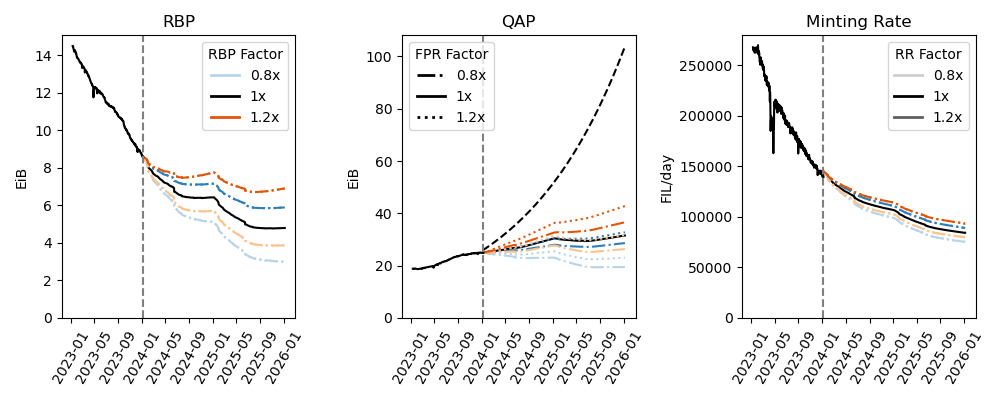

In [49]:
plot_power_scenarios(simconfig2results)

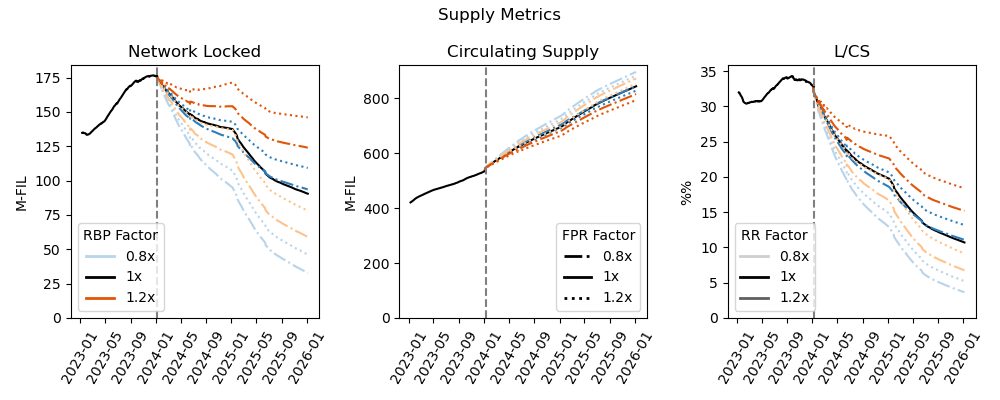

In [50]:
plot_supply_scenarios(simconfig2results)

/tmp/ipykernel_6722/3171138651.py:176: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))


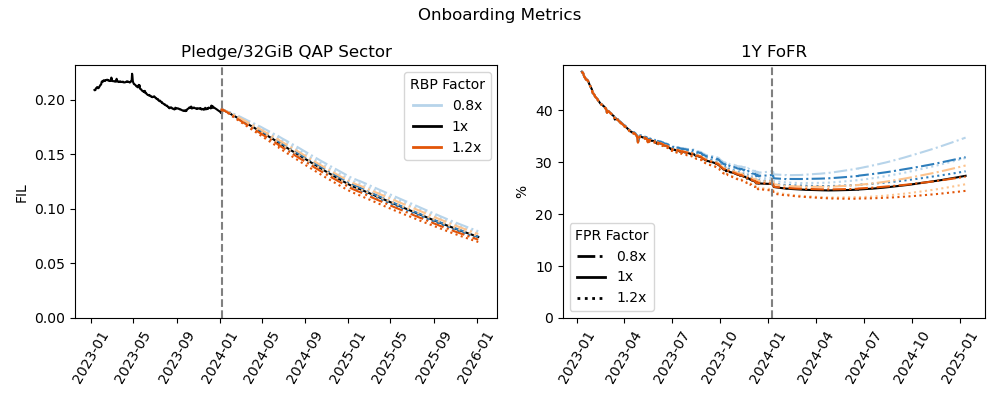

In [51]:
plot_onboarding_scenarios(simconfig2results, rbp_factors, rr_factors, fpr_factors)

### Check if Incentives to Delay Onboarding

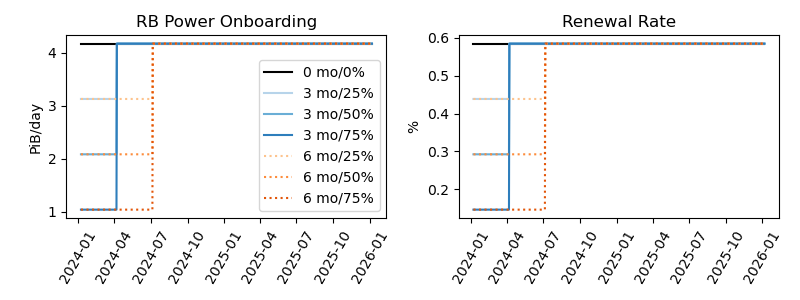

In [52]:
delay_vec = [90, 180]
pct_population_delay_vec = [0.25, 0.5, 0.75]

sim_config = list(itertools.product(delay_vec, pct_population_delay_vec))
sim_config.insert(0, (0, 0))

config2inputs = {}
for cfg in sim_config:
    delay, pct_population_delay = cfg

    if delay == 0:
        rbp_stitched = np.ones(forecast_length) * hist_median_rbp
        rr_stitched = np.ones(forecast_length) * hist_median_rr
    else:
        remaining_len = forecast_length-delay
        rbp_stitched = np.concatenate(
            [np.ones(delay)*hist_median_rbp*(1-pct_population_delay), np.ones(remaining_len)*hist_median_rbp]
        )
        rr_stitched = np.concatenate(
            [np.ones(delay)*hist_median_rr*(1-pct_population_delay), np.ones(remaining_len)*hist_median_rr]
        )
    config2inputs[cfg] = {
        'rbp': rbp_stitched,
        'rr': rr_stitched
    }

# plot the inputs
tt = pd.date_range(current_date, periods=forecast_length, freq='D')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
colors = [mpl.colormaps['Blues'], mpl.colormaps['Oranges'], mpl.colormaps['Greens'], mpl.colormaps['Purples']]
cvec_idx = np.linspace(0.3, 0.7, len(pct_population_delay_vec))
for config in config2inputs.keys():  
    delay, pct_population_delay = config
    axx = ax[0]
    if delay == 0:
        color = 'k'
    else:
        color = colors[delay_vec.index(delay)](cvec_idx[pct_population_delay_vec.index(pct_population_delay)])
    if delay == 180:
        linestyle = ":"
    else:
        linestyle = None

    axx.plot(tt, config2inputs[config]['rbp'], label='%d mo/%d%%' % (delay//30, pct_population_delay*100), color=color, linestyle=linestyle)
    axx.set_title('RB Power Onboarding')
    axx.set_ylabel('PiB/day')  
    axx = ax[1]
    axx.plot(tt, config2inputs[config]['rr'], label='%d mo/%d%%' % (delay//30, pct_population_delay*100), color=color, linestyle=linestyle)
    axx.set_title('Renewal Rate')
    axx.set_ylabel('%')

ax[0].legend()
for tick in ax[0].get_xticklabels(): tick.set_rotation(60)
for tick in ax[1].get_xticklabels(): tick.set_rotation(60)

# plt.suptitle('Delay: %d' % (d,))
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'delay_inputs.png'))

In [53]:
lock_target = 0.3
sector_duration = 365

simconfig2results_delay = {}

for config, inputs in config2inputs.items():
    rbp_vec = jnp.asarray(inputs['rbp'])
    rr_vec = jnp.asarray(inputs['rr'])
    fpr_vec = jnp.ones(forecast_length) * hist_median_fpr

    simulation_results = sim.run_sim(
        rbp_vec,
        rr_vec,
        fpr_vec,
        lock_target,
    
        start_date,
        current_date,
        forecast_length,
        sector_duration,
        offline_data
    )
    simconfig2results_delay[config] = simulation_results

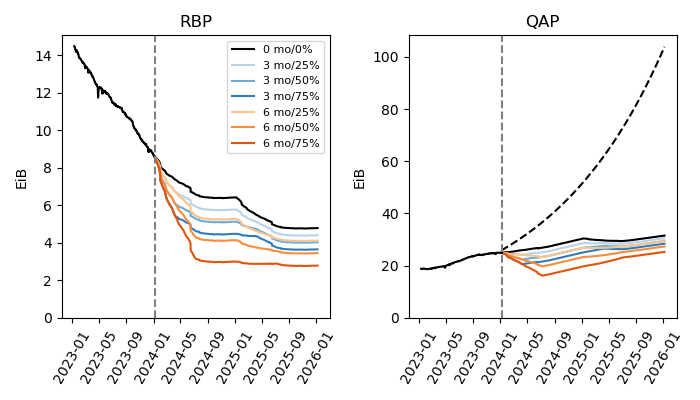

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,4))

axx = ax[0]
for sim_config, sim_results in simconfig2results_delay.items():
    delay, pct_population_delay = sim_config
    if delay == 0:
        color = 'k'
    else:
        color = colors[delay_vec.index(delay)](cvec_idx[pct_population_delay_vec.index(pct_population_delay)])
        
    axx.plot(macro_t, sim_results['rb_total_power_eib'], label='%d mo/%d%%' % (delay//30, pct_population_delay*100), color=color)
axx.plot(hist_df_merged['date'], hist_df_merged['total_raw_power_eib'], color='k')
axx.set_ylabel('EiB')
axx.set_title('RBP')
for tick in axx.get_xticklabels(): tick.set_rotation(60)
axx.set_ylim(bottom=0)
axx.axvline(current_date, color='grey', linestyle='--')
axx.legend(fontsize=8)

axx = ax[1]
for sim_config, sim_results in simconfig2results_delay.items():
    delay, pct_population_delay = sim_config
    if delay == 0:
        color = 'k'
    else:
        color = colors[delay_vec.index(delay)](cvec_idx[pct_population_delay_vec.index(pct_population_delay)])
        
    axx.plot(macro_t, sim_results['qa_total_power_eib'], label='%d mo/%d%%' % (delay//30, pct_population_delay*100), color=color)
axx.plot(hist_df_merged['date'], hist_df_merged['total_qa_power_eib'], color='k')
axx.plot(macro_t, sim_results['network_baseline_EIB'], color='k', linestyle='--')
axx.set_ylabel('EiB')
axx.set_title('QAP')
for tick in axx.get_xticklabels(): tick.set_rotation(60)
axx.set_ylim(bottom=0)
axx.axvline(current_date, color='grey', linestyle='--')

# plt.suptitle('Power Metrics')
plt.tight_layout()

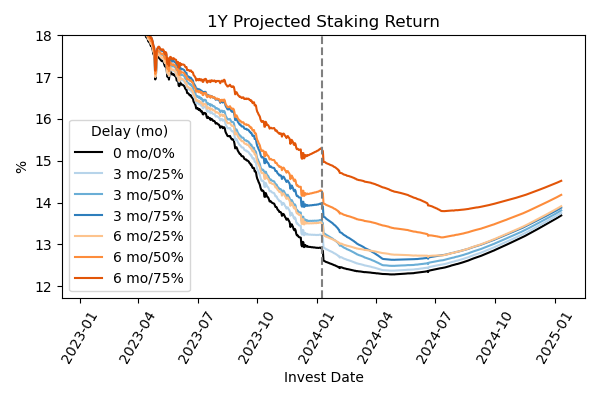

In [55]:
# plot pledge + FoFR
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

config2stakingreturn = {}
staking_return_pct = 0.5
axx = ax
for sim_config, sim_results in simconfig2results_delay.items():
    delay, pct_population_delay = sim_config
    if delay == 0:
        color = 'k'
    else:
        color = colors[delay_vec.index(delay)](cvec_idx[pct_population_delay_vec.index(pct_population_delay)])
        
    dpqq_full = np.concatenate([hist_df_merged['pledge'].values, sim_results['day_pledge_per_QAP']])
    drps_full = np.concatenate([hist_df_merged['day_rewards_per_sector'].values, sim_results['day_rewards_per_sector']])
    days_1y = 365
    rps_1y = np.convolve(drps_full, np.ones(days_1y), mode='full')[days_1y-1:1-days_1y]
    roi_1y = rps_1y / dpqq_full[:1-days_1y]
    fofr_tvec = pd.date_range(hist_df_merged['date'].iloc[0], periods=len(roi_1y), freq='D')
    
    axx.plot(fofr_tvec, roi_1y*100*staking_return_pct, label='%d mo/%d%%' % (delay//30, pct_population_delay*100), color=color)
    config2stakingreturn[sim_config] = {'t': fofr_tvec, 'staking_return': roi_1y*100*staking_return_pct}
    
axx.set_ylabel('%')
axx.set_title('1Y Projected Staking Return')
for tick in axx.get_xticklabels(): tick.set_rotation(60)
axx.set_ylim(top=18)
axx.axvline(current_date, color='grey', linestyle='--')
axx.legend(title="Delay (mo)")
axx.set_xlabel('Invest Date')
# plt.suptitle('Onboarding Metrics')
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'delayed_onboarding.png'))

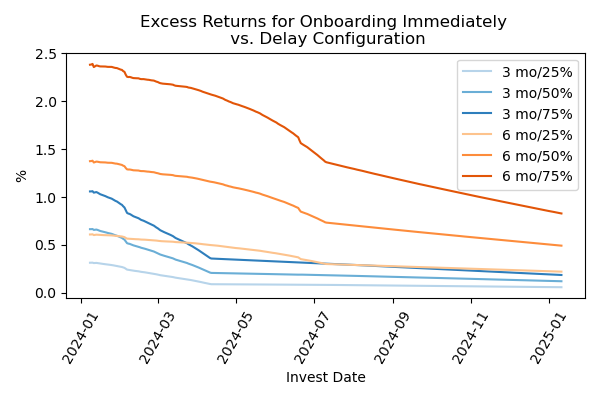

In [56]:
# plot the excess returns that are afforded to people who invest now vs. delay
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

delay2excessreturns = {}
for sim_config, sim_results in config2stakingreturn.items():
    delay, pct_population_delay = sim_config
    if delay == 0:
        continue
    else:
        color = colors[delay_vec.index(delay)](cvec_idx[pct_population_delay_vec.index(pct_population_delay)])

    x_zerodelay = config2stakingreturn[(0,0)]
    t = sim_results['t']
    staking_return_delay = sim_results['staking_return']
    staking_return_nodelay = x_zerodelay['staking_return']
    
    excess_return = staking_return_delay - staking_return_nodelay

    ix = np.where(t==pd.to_datetime(current_date))[0][0]
    er = excess_return[ix:]
    tt = pd.date_range(current_date, periods=len(er), freq='D')
    
    # delay2excessreturns[d] = {'t': tt, 'excess_return': er}
    ax.plot(tt, er, label='%d mo/%d%%' % (delay//30, pct_population_delay*100), color=color)

for tick in ax.get_xticklabels(): tick.set_rotation(60)
ax.legend()
ax.set_ylabel('%')
ax.set_xlabel('Invest Date')
ax.set_title('Excess Returns for Onboarding Immediately \n vs. Delay Configuration')
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'delayed_onboarding_excess_returns.png'))

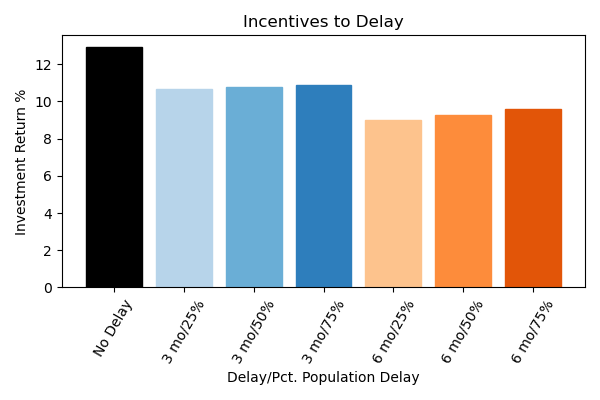

In [57]:
# tap off points from FoFR curves at delay periods and assume risk-free rate
# then, show total return expected
rfr = 0.05
config2return = {}
for sim_config, sim_results in config2stakingreturn.items():
    delay, pct_population_delay = sim_config
    t = sim_results['t']
    staking_return = sim_results['staking_return']
    
    target_date = pd.to_datetime(current_date + timedelta(days=delay))
    ix = np.where(t==target_date)[0]
    ix_zero = np.where(t==pd.to_datetime(current_date))[0]
    
    dd = delay/30.
    return_from_delay = 100*(1+rfr/12.0*dd)
    total_return = return_from_delay*(1+(staking_return[ix]/100)*(12-dd)/12)
    config2return[sim_config] = total_return[0]-100

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
barlist = ax.bar(range(len(config2return)), list(config2return.values()), align='center')
ax.set_xticks(range(len(config2return)), ['%d mo/%d%%' % (x[0]//30., x[1]*100) if ii!=0 else 'No Delay' for ii, x in enumerate(config2return.keys())])
for tick in ax.get_xticklabels(): tick.set_rotation(60)

barlist[0].set_color('k')
barlist[1].set_color(colors[0](0.3))
barlist[2].set_color(colors[0](0.5))
barlist[3].set_color(colors[0](0.7))
barlist[4].set_color(colors[1](0.3))
barlist[5].set_color(colors[1](0.5))
barlist[6].set_color(colors[1](0.7))

ax.set_xlabel('Delay/Pct. Population Delay')
ax.set_ylabel('Investment Return %')
ax.set_title('Incentives to Delay')
# ax.set_yscale('log')
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'delayed_onboarding_incentives.png'))


### Check Various Levels of Onboarding for how fast they catch up to Baseline

In [58]:
# get additional historical data for plotting purposes
@disk_utils.cache_data(directory=offline_info_dir)
def get_additional_historical_onboarding_data():
    additional_historical_data = data.get_simulation_data(token, current_date-timedelta(days=90), current_date, end_date)
    return {
        'additional_historical_data': additional_historical_data
    }
x = get_additional_historical_onboarding_data()
locals().update(x)

In [59]:
lock_target = 0.3
sector_duration = 365
# fix RR & FPR
rbp_values = [8, 10, 12]
cvec_idx = np.linspace(0.2,0.8,len(rbp_values))

rr_factors = [0.8, 1.0, 1.2]
fpr_factors = [0.8, 1.0, 1.2]
factors = list(itertools.product(*[rr_factors, fpr_factors]))

rbp2results = {}
for rbp in rbp_values:
    qap_catchup_results = []
    for factor in factors:
        rr_factor, fpr_factor = factor[0], factor[1]
        rbp_vec = jnp.ones(forecast_length)*rbp
        rr_vec = jnp.ones(forecast_length)*min(0.99, hist_median_rr*rr_factor)
        fpr_vec = jnp.ones(forecast_length)*min(0.99, hist_median_fpr*fpr_factor)
        simulation_results = sim.run_sim(
            rbp_vec,
            rr_vec,
            fpr_vec,
            lock_target,
        
            current_date-timedelta(days=90),
            current_date,
            forecast_length,
            sector_duration,
            additional_historical_data
        )
        qap_catchup_results.append(simulation_results)
    rbp2results[rbp] = qap_catchup_results

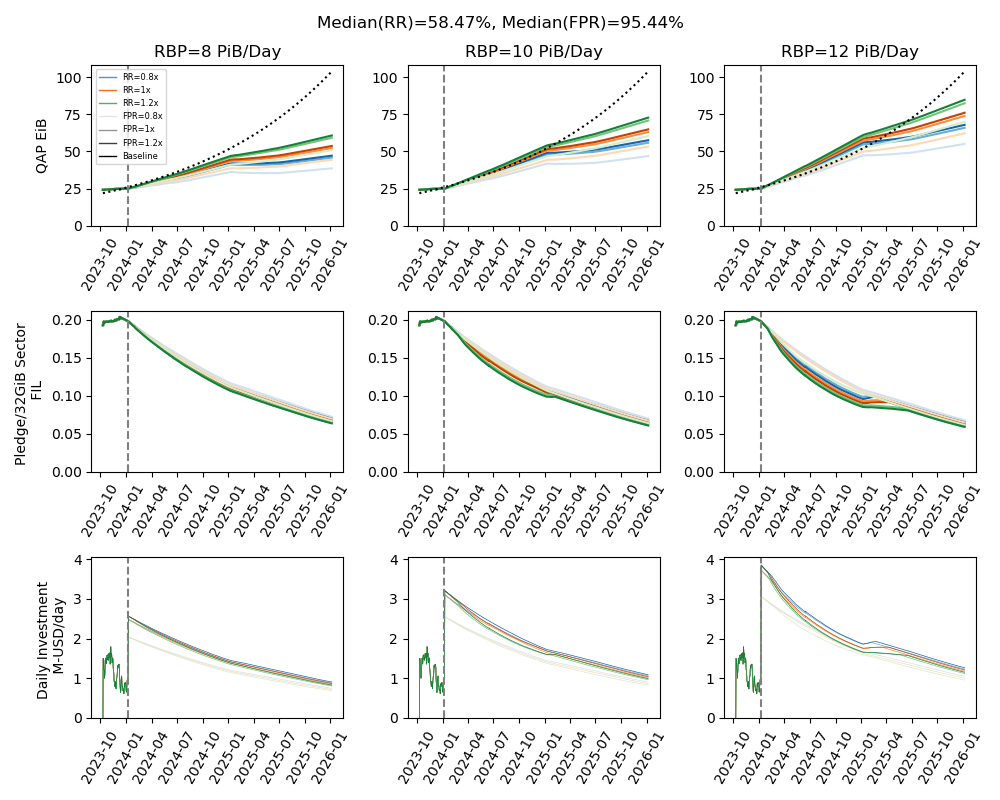

In [60]:
colors = [mpl.colormaps['Blues'], mpl.colormaps['Oranges'], mpl.colormaps['Greens'], mpl.colormaps['Purples']]
cvec_idx = np.linspace(0.2,0.8,len(fpr_factors))
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,8))

FIL_price = 5.00
reinvestment_amt = 0.8
sectors32gib_per_pib = 1048576/32
current_day = (current_date - start_date).days

new_tvec = pd.date_range(current_date-timedelta(days=90), periods=forecast_length+90, freq='D')
config2totalinvestment = {}
config2exceedbaseline = {}
for xx, rbp_value in enumerate(rbp_values):
    qap_catchup_results = rbp2results[rbp_value]
    
    axx = ax[0,xx]
    for ii, factor in enumerate(factors):
        rr_factor, fpr_factor = factor[0], factor[1]
        cc = colors[rr_factors.index(rr_factor)](cvec_idx[fpr_factors.index(fpr_factor)])
        qa_y = qap_catchup_results[ii]['qa_total_power_eib']
        baseline_y = qap_catchup_results[ii]['network_baseline_EIB']
        axx.plot(new_tvec, qa_y, color=cc)

        ix = np.where(new_tvec==pd.to_datetime(current_date+timedelta(days=365)))[0][0]
        last_qa_value = qa_y[ix]
        last_baseline_value = baseline_y[ix]
        config2exceedbaseline[(rbp_value, rr_factor, fpr_factor)] = (float(last_qa_value) >= float(last_baseline_value))
    axx.plot(new_tvec, qap_catchup_results[0]['network_baseline_EIB'], color='k', linestyle=':')
    axx.axvline(current_date, linestyle='--', color='grey')
    if xx == 0:
        axx.set_ylabel('QAP EiB')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.set_title('RBP=%d PiB/Day' % (rbp_value,))
    axx.set_ylim(bottom=0)

    if xx == 0:
        # make custom legend
        custom_lines = [
            Line2D([0], [0], color=colors[0](0.6), lw=1),
            Line2D([0], [0], color=colors[1](0.6), lw=1),
            Line2D([0], [0], color=colors[2](0.6), lw=1),
            Line2D([0], [0], color=mpl.colormaps['Greys'](cvec_idx[0]), lw=1),
            Line2D([0], [0], color=mpl.colormaps['Greys'](cvec_idx[1]), lw=1),
            Line2D([0], [0], color=mpl.colormaps['Greys'](cvec_idx[2]), lw=1),
            Line2D([0], [0], color='k', lw=1),
        ]
        axx.legend(custom_lines, ['RR=0.8x', 'RR=1x', 'RR=1.2x','FPR=0.8x', 'FPR=1x', 'FPR=1.2x', 'Baseline'], fontsize=6)

    axx = ax[1,xx]
    for ii, factor in enumerate(factors):
        rr_factor, fpr_factor = factor[0], factor[1]
        cc = colors[rr_factors.index(rr_factor)](cvec_idx[fpr_factors.index(fpr_factor)])
        axx.plot(new_tvec, qap_catchup_results[ii]['day_pledge_per_QAP'], color=cc)
    axx.axvline(current_date, linestyle='--', color='grey')
    if xx == 0:
        axx.set_ylabel('Pledge/32GiB Sector \n FIL')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.set_ylim(bottom=0)
    
    axx = ax[2,xx]
    for ii, factor in enumerate(factors):
        rr_factor, fpr_factor = factor[0], factor[1]
        cc = colors[rr_factors.index(rr_factor)](cvec_idx[fpr_factors.index(fpr_factor)])
        y_val_fil_new = qap_catchup_results[ii]['day_locked_pledge'] - qap_catchup_results[ii]['day_renewed_pledge']
        y_val_musd = (y_val_fil_new*FIL_price)/1e6
        axx.plot(new_tvec, y_val_musd, color=cc, linewidth=0.5)
        
        ix_start = np.where(new_tvec==pd.to_datetime(current_date))[0][0]
        ix_end = np.where(new_tvec==pd.to_datetime(current_date+timedelta(days=365)))[0][0]
        config2totalinvestment[(rbp_value, rr_factor, fpr_factor)] = np.sum(y_val_musd[ix_start:ix_end])
    axx.axvline(current_date, linestyle='--', color='grey')
    if xx == 0:
        axx.set_ylabel('Daily Investment \n M-USD/day')
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.set_ylim(bottom=0)
    
# # sync the axes
ax[0,0].sharey(ax[0,2])
ax[0,1].sharey(ax[0,2])

ax[1,0].sharey(ax[1,2])
ax[1,1].sharey(ax[1,2])

ax[2,0].sharey(ax[2,2])
ax[2,1].sharey(ax[2,2])

plt.suptitle('Median(RR)=%0.02f%%, Median(FPR)=%0.02f%%' % (hist_median_rr*100, hist_median_fpr*100))
plt.tight_layout()

plt.savefig(os.path.join(save_dir, 'investment.png'))

In [61]:
def get_heatmap_data(rbp_val):
    y = np.zeros((len(rr_factors), len(fpr_factors)))
    for k, v in config2totalinvestment.items():
        if k[0] == rbp_val:
            rr_idx = rr_factors.index(k[1])
            fpr_idx = fpr_factors.index(k[2])
            y[rr_idx,fpr_idx] = v
    return y

def get_baseline_exceed_condition(rbp_val):
    y = np.zeros((len(rr_factors), len(fpr_factors)))
    for k, v in config2exceedbaseline.items():
        if k[0] == rbp_val:
            rr_idx = rr_factors.index(k[1])
            fpr_idx = fpr_factors.index(k[2])
            y[rr_idx,fpr_idx] = v
    return y


(array([], dtype=int64), array([], dtype=int64))
(array([2, 2]), array([1, 2]))
(array([0, 0, 1, 1, 2, 2, 2]), array([1, 2, 1, 2, 0, 1, 2]))


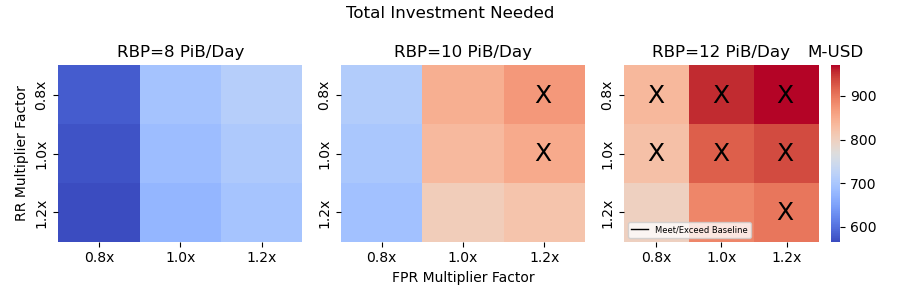

In [62]:
# plt.figure(figsize=(4,3))
# plt.hist(config2totalinvestment.values())
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9,3))

rbp8_heatmap = get_heatmap_data(8)
rbp10_heatmap = get_heatmap_data(10)
rbp12_heatmap = get_heatmap_data(12)
min_val = min(np.min(rbp8_heatmap), np.min(rbp10_heatmap), np.min(rbp12_heatmap))
max_val = max(np.max(rbp8_heatmap), np.max(rbp10_heatmap), np.max(rbp12_heatmap))

xtl = ['%0.1fx' % x for x in fpr_factors]
ytl = ['%0.1fx' % x for x in rr_factors]

idx2coord = {
    0:0.33/2,
    1:0.33 + 0.33/2,
    2:0.33*2 + 0.33/2
}

axx = ax[0]
sns.heatmap(rbp8_heatmap, ax=axx, xticklabels=xtl, yticklabels=ytl, cbar=False, vmin=min_val, vmax=max_val, cmap="coolwarm")
axx.set_title('RBP=8 PiB/Day')
axx.set_ylabel('RR Multiplier Factor')
annot_idxs = np.where(get_baseline_exceed_condition(8))
print(annot_idxs)
if len(annot_idxs[0]) > 0:
    for ii in range(len(annot_idxs[0])):
        xix = annot_idxs[0][ii]
        yix = annot_idxs[1][ii]
        # translate to heatmap, which is between 0 and 1
        spacing = 1.0/len(fpr_factors)
        axx.text(idx2coord[xix], idx2coord[yix], "X", fontsize=18, color='k', ha='center', va='center', transform=axx.transAxes)

axx = ax[1]
sns.heatmap(rbp10_heatmap, ax=axx, xticklabels=xtl, yticklabels=ytl, cbar=False, vmin=min_val, vmax=max_val, cmap="coolwarm")
axx.set_title('RBP=10 PiB/Day')
axx.set_xlabel('FPR Multiplier Factor')
annot_idxs = np.where(get_baseline_exceed_condition(10))
print(annot_idxs)
if len(annot_idxs[0]) > 0:
    for ii in range(len(annot_idxs[0])):
        xix = annot_idxs[0][ii]
        yix = annot_idxs[1][ii]
        # translate to heatmap, which is between 0 and 1
        spacing = 1.0/len(fpr_factors)
        axx.text(idx2coord[xix], idx2coord[yix], "X", fontsize=18, color='k', ha='center', va='center', transform=axx.transAxes)

axx = ax[2]
sns.heatmap(rbp12_heatmap, ax=axx, xticklabels=xtl, yticklabels=ytl, vmin=min_val, vmax=max_val, cmap="coolwarm")
axx.collections[0].colorbar.ax.set_title('M-USD')
axx.set_title('RBP=12 PiB/Day')
annot_idxs = np.where(get_baseline_exceed_condition(12))
print(annot_idxs)
if len(annot_idxs[0]) > 0:
    for ii in range(len(annot_idxs[0])):
        xix = annot_idxs[0][ii]
        yix = annot_idxs[1][ii]
        # translate to heatmap, which is between 0 and 1
        spacing = 1.0/len(fpr_factors)
        axx.text(idx2coord[xix], idx2coord[yix], "X", fontsize=18, color='k', ha='center', va='center', transform=axx.transAxes)

custom_lines = [
    Line2D([0], [0], color='k', lw=1),
]
axx.legend(custom_lines, ['Meet/Exceed Baseline'], fontsize=6, loc='lower left')
plt.suptitle('Total Investment Needed')
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'investment_total.png'))

### DataCap Worksheet

In [63]:
# data manually encoded from https://clients.datacapstats.io/
# We use the following charts:
#   DataCap Allocation Requested for past 90 days
#   DataCap Allocation Allocated for past 90 days
datacap_t = pd.date_range(date(2023, 10, 18), periods=88, freq='D')
datacap_allocated_pib = np.asarray([
    6.79, 1.49, 1, 3.21, 3.65, 16.2, 64./1048576, 2, 12.85, 5.68, 32./1048576, 1.56, 1.49, 6.17, 
    950./1024, 7.9, 3.28, 2, 0, 8.99, 6.67, 4.7, 7.02, 8, 400.03/1024, 0, 6.95, 12.15, 5.79, 32./1048576, 32./1048576, 0, 0, 32./1048576, 
    11.02, 10.99, 6.63, 1.39, 0, 3.34, 2.78, 4.95, 6.34, 4, 5, 6, 64./1048576,
    5.78, 4.5, 6.65, 8.24, 8.49, 32./1048576, 0, 11.68, 32./1048576, 0, 0, 512.03/1024, 0, 64./1048576, 32./1048576,
    64./1048576, 0, 8.77, 11.19, 0, 0, 4, 4, 12.56, 11.56, 7.58, 1.34, 0, 0, 1.28, 500./1024, 3.25, 7.41, 
    0, 32./1048576, 2.98, 3.5, 5.48, 4.85, 4, 6.67
])
datacap_requested_pib = np.asarray([
    2.1, 6.73, 4.23, 3.7, 2.95, 8.9, 3.5, 2.65, 5.21, 5, 2.54, 1.05, 2.25, 800./1024, 6.73, 1, 2, 1.24, 1.34, 
    6.53, 5.12, 5.89, 7.32, 4.17, 2.39, 2.16, 5.33, 12.49, 4.62, 1.56, 200./1024, 1.37, 712./1024, 1.58, 1.58, 2.44, 1.17, 
    2.39, 0, 0, 3, 3.9, 1.95, 1.05, 4.1, 0, 1.74, 8.28, 4.24, 4.05, 2.4, 6.45, 0, 0.5, 800./1024, 0, 0, 0,
    10.51, 2, 0, 0, 1.95, 0, 8.31, 9.46, 0, 0, 0, 2.98, 6.54, 4, 0, 0, 0.5, 0.5, 0.5, 500./1024, 1000./1024, 2.5, 0.5, 
    0, 0.5, 0, 1.73, 2, 1.95, 0.5
])
datacap_df = pd.DataFrame({
    'date': datacap_t,
    'allocated': datacap_allocated_pib,
    'requested': datacap_requested_pib
})
# plot a moving average of 7 days of allocated vs requested
datacap_df['Requested (MA7)'] = datacap_df['requested'].rolling(7).mean()
datacap_df['Allocated (MA7)'] = datacap_df['allocated'].rolling(7).mean()

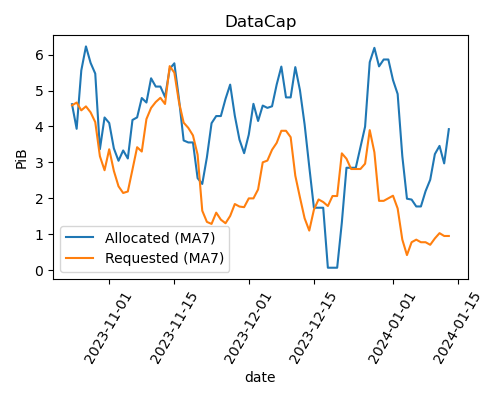

In [64]:

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))

# axx = ax[0]
# alloc_req_df = datacap_df[['date', 'allocated', 'requested']].melt(id_vars='date')
# sns.lineplot(x='date', y='value', hue='variable', data=alloc_req_df, ax=axx)

axx = ax
alloc_req_df = datacap_df[['date', 'Allocated (MA7)', 'Requested (MA7)']].melt(id_vars='date')
g = sns.lineplot(x='date', y='value', hue='variable', data=alloc_req_df, ax=axx)
g.legend_.set_title('')
axx.set_title('DataCap')
for tick in axx.get_xticklabels(): tick.set_rotation(60)
axx.set_ylabel('PiB')

plt.tight_layout()